In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata, split_in_train_and_test
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.metadata_processing.process_sounds_metadata import make_fixed_size_sounds
from src.audiodata_processing.process_waves import process_waves, butter_highpass_filter, denoise_recording
from src.audiodata_processing.extract_features_from_wave import extract_specs, extract_melspecs
from sklearn.metrics import precision_recall_curve
from collections import defaultdict
from src.util import make_image
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from src.deep_learning.splitter_analysis import *

2022-02-13 18:34:23.865199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-13 18:34:24.876690: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 18:34:24.879926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-13 18:34:25.019025: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-13 18:34:25.019060: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BUBUNTU3000): /proc/driver/nvidia/version does not exist


In [2]:
path_to_models = PATH_TO_PROJECT + 'models/splitter/networks/'
path_to_datasets = PATH_TO_PROJECT + 'models/splitter/datasets/'
all_models = os.listdir(path_to_models)
dataset_name = '/res=2048_step1024_nfft=512_nmel=40_rec-denoise=False_highpass=3000/'
model_name = '/augment/'

model = tf.keras.models.load_model(path_to_models + dataset_name + model_name) 

path_to_recs = PATH_TO_PROJECT + '/data/hvdkleinannotated/recordings/'


2022-02-13 18:34:25.087261: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 18:34:25.087415: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
rec_names = [f for f in os.listdir(path_to_recs) if '.npy' in f]
rec_names

['hvdkleinannotated_02-09-19_0000002.npy',
 'hvdkleinannotated_02-09-19_0000003.npy',
 'hvdkleinannotated_02-09-19_0000001.npy']

In [4]:
per_rec_dict = defaultdict(dict)

with open(path_to_datasets + dataset_name + '/params_dict.pickle', 'rb') as f:
    all_params_dict = pickle.load(f)

for rec_name in rec_names:
    txt_name = rec_name.replace('npy', 'txt')
    # Load the recording and txt
    rec = np.load(path_to_recs + rec_name)
    txt = pd.read_csv(path_to_recs + txt_name, sep='\t')
    txt = txt.sort_values(by='s').reset_index(drop=True)
    
    true_rec_labels, true_sound_inds = txt_to_rec_labels(rec, txt, all_params_dict['sr'])
    
    # Run splitter
    rec_predictions, pred_rec_probs = run_splitter(rec, model, all_params_dict)
    
    per_rec_dict[rec_name]['true_rec_labels'] = true_rec_labels
    per_rec_dict[rec_name]['true_sound_inds'] = true_sound_inds
    per_rec_dict[rec_name]['rec_predictions'] = rec_predictions
    per_rec_dict[rec_name]['pred_rec_probs'] = pred_rec_probs
    per_rec_dict[rec_name]['txt'] = txt
    per_rec_dict[rec_name]['rec'] = rec

2022-02-13 18:35:05.271450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-13 18:35:05.296260: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


In [5]:
precisions_list = []
recalls_list = []
thresholds_list = []
for rec_name in per_rec_dict:
    precision, recall, thresholds = precision_recall_curve(per_rec_dict[rec_name]['true_rec_labels'], 
                                                           per_rec_dict[rec_name]['pred_rec_probs'])
    precisions_list.append(precision)
    recalls_list.append(recall)
    thresholds_list.append(thresholds)

0.009180426597595215

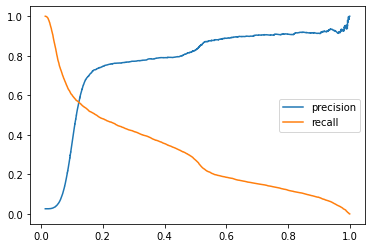

In [20]:
weight_recall = 2
ind = 2

plt.plot(thresholds_list[ind], precisions_list[ind][:-1], label='precision')
plt.plot(thresholds_list[ind], recalls_list[ind][:-1], label='recall')
_ = plt.legend()
best_th_ind = np.argmax(precisions_list[ind] + weight_recall * recalls_list[ind])
best_th = thresholds[best_th_ind]
best_th

In [6]:
mean_precision = np.mean(precisions_list, 0)
mean_recall = np.mean(recalls_list, 0)
mean_thresholds = np.mean(thresholds_list, 0)

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (139136,) (214734,) 

0.46734733507037163

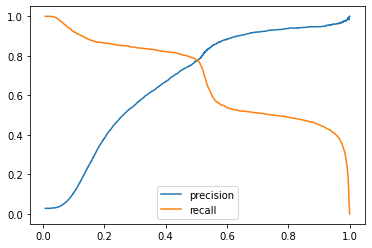

In [70]:
weight_recall = 2
plt.plot(mean_thresholds, mean_precision[:-1], label='precision')
plt.plot(mean_thresholds, mean_recall[:-1], label='recall')
_ = plt.legend()
best_th_ind = np.argmax(mean_precision + weight_recall * mean_recall)
best_th = thresholds[best_th_ind]
best_th

In [21]:
sr = 22050
th = .2
per_rec_precision_recall = defaultdict(dict)
recall_results_list = []
precision_results_list = []
count_precision_list = []
count_recall_list = []

for rec_name in per_rec_dict:
    print('Computing for %s' % rec_name)
    true_rec_labels = per_rec_dict[rec_name]['true_rec_labels']
    true_sound_inds = per_rec_dict[rec_name]['true_sound_inds']
    rec_predictions = per_rec_dict[rec_name]['rec_predictions']
    pred_rec_probs = per_rec_dict[rec_name]['pred_rec_probs']
    txt = per_rec_dict[rec_name]['txt']
    pred_rec_labels, pred_sound_inds = map_prediction_to_sounds(pred_rec_probs, th, min_length=512)

    true_pixel_to_sound_index = np.zeros(len(true_rec_labels), dtype='int')
    for ind, (s, e) in enumerate(txt[['s', 'e']].values):
        s_int, e_int = int(s * sr), int(e * sr)
        true_pixel_to_sound_index[s_int: e_int] = ind + 1

    true_sound_ind_to_pixels = {}
    for ind, (s, e) in enumerate(txt[['s', 'e']].values):
        s_int, e_int = int(s * sr), int(e * sr)
        true_sound_ind_to_pixels[ind + 1] = (s_int, e_int)

    pred_pixel_to_sound_index = np.zeros(len(true_rec_labels), dtype='int')
    for ind, (s_int, e_int) in enumerate(pred_sound_inds):
        pred_pixel_to_sound_index[s_int: e_int] = ind + 1

    pred_sound_ind_to_pixels = {}
    for ind, (s_int, e_int) in enumerate(pred_sound_inds):
        pred_sound_ind_to_pixels[ind + 1] = (s_int, e_int)

    precision_results, precision_results_count = study_precision(pred_sound_inds, true_pixel_to_sound_index, 
                                                                 true_sound_ind_to_pixels,  
                                                                 full_cover_th=0.85, partial_cover_th=0.5)
    
    recall_results, recall_results_count = study_recall(true_sound_inds, pred_rec_labels, 
                                                            pred_pixel_to_sound_index, 
                                                            detected_th=0.8, partly_detected_th=0.5,
                                                            partial_cover_th=.3)
    
    per_rec_precision_recall[rec_name]['precision_results'] = precision_results
    per_rec_precision_recall[rec_name]['precision_results_count'] = precision_results_count
    per_rec_precision_recall[rec_name]['recall_results'] = recall_results
    per_rec_precision_recall[rec_name]['recall_results_count'] = recall_results_count

Computing for hvdkleinannotated_02-09-19_0000002.npy
Computing for hvdkleinannotated_02-09-19_0000003.npy
Computing for hvdkleinannotated_02-09-19_0000001.npy


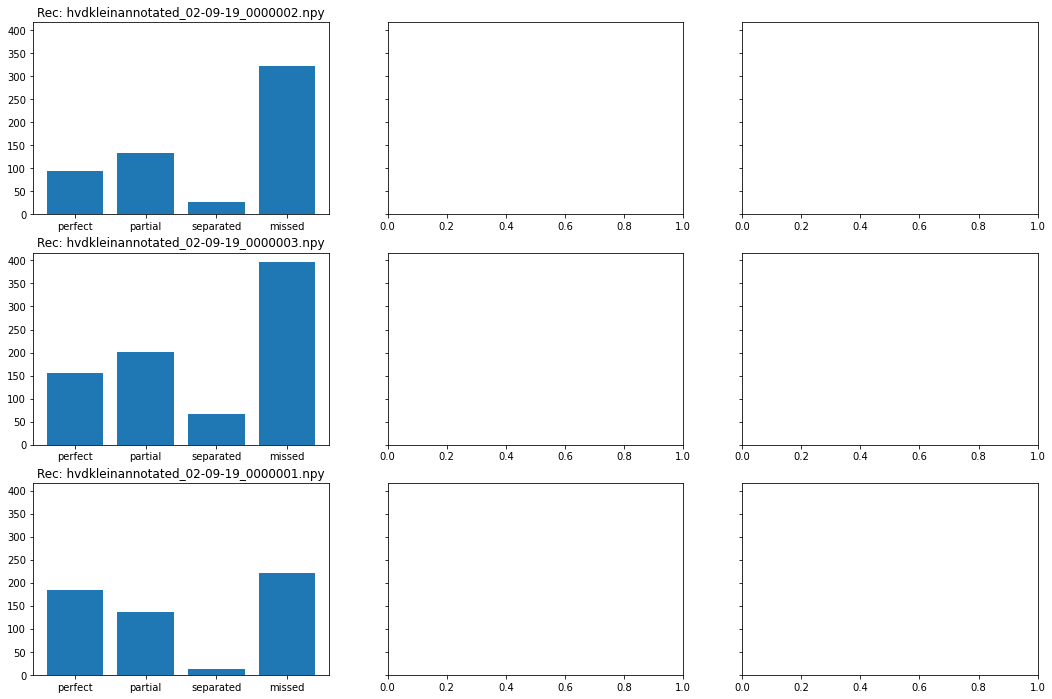

In [22]:

result_group_dict = {'fully_in_1': 'perfect', 'partly_in_1': 'partial', 'missed': 'missed'}
plot_x = 3
plot_y = 3
fig, axs = plt.subplots(plot_y, plot_x, figsize=(plot_x *6, plot_y * 4), sharex=False, sharey=True)

for xi in range(plot_x):
    for yi in range(plot_y):
        rec_ind = xi * plot_y + yi
        if rec_ind >= len(rec_names):
            break
        rec_name = rec_names[rec_ind]
        recall_results_count = per_rec_precision_recall[rec_name]['recall_results_count']
        recall_results_grouped = {}
        for key, val in recall_results_count.items():
            group_key = result_group_dict[key] if key in result_group_dict else 'separated'
            if group_key in recall_results_grouped:
                recall_results_grouped[group_key] += val
            else:
                recall_results_grouped[group_key] = val
        x = sorted(recall_results_grouped.keys())
        x = ['perfect', 'partial', 'separated', 'missed']
        y = [recall_results_grouped[k] if k in recall_results_grouped else 0 for k in x]
        _ =  axs[yi, xi].bar(x, y)
        axs[yi, xi].set_title('Rec: %s' % rec_name)

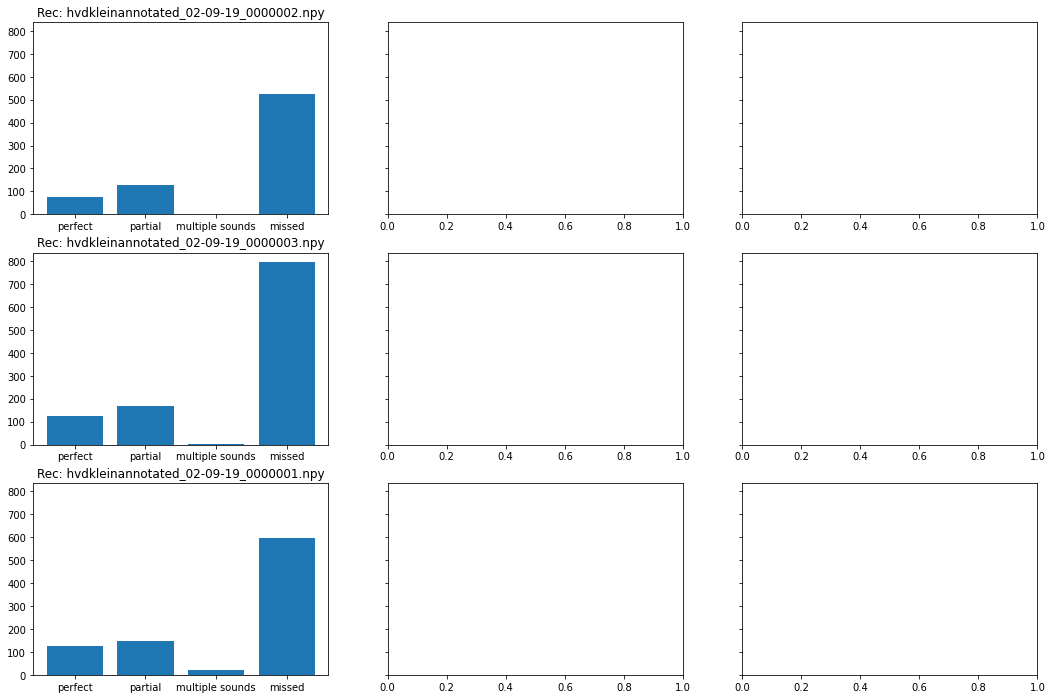

In [23]:

result_group_dict = {'1full_0partial': 'perfect', '0full_1partial': 'partial', '0full_0partial': 'missed'}
plot_x = 3
plot_y = 3
fig, axs = plt.subplots(plot_y, plot_x, figsize=(plot_x *6, plot_y * 4), sharex=False, sharey=True)

for xi in range(plot_x):
    for yi in range(plot_y):
        rec_ind = xi * plot_y + yi
        if rec_ind >= len(rec_names):
            break
        rec_name = rec_names[rec_ind]
        precision_results_count = per_rec_precision_recall[rec_name]['precision_results_count']
        precision_results_grouped = {}
        for key, val in precision_results_count.items():
            group_key = result_group_dict[key] if key in result_group_dict else 'multiple sounds'
            if group_key in precision_results_grouped:
                precision_results_grouped[group_key] += val
            else:
                precision_results_grouped[group_key] = val
        x = ['perfect', 'partial', 'multiple sounds', 'missed']
        y = [precision_results_grouped[k] if k in precision_results_grouped else 0 for k in x]
        _ =  axs[yi, xi].bar(x, y)
        axs[yi, xi].set_title('Rec: %s' % rec_name)

In [24]:
rec_names

['hvdkleinannotated_02-09-19_0000002.npy',
 'hvdkleinannotated_02-09-19_0000003.npy',
 'hvdkleinannotated_02-09-19_0000001.npy']